<h1>Natural Language Processing with Disaster Tweets</h1>
Predict which Tweets are about real disasters and which ones are not

<h1>The Problem</h1>

In the fast-paced technology era, the speed of information dissemination on social networks far surpasses the capabilities of traditional media outlets.

Twitter, now referred to as 'X', stands out as one of the most pivotal communication channels during times of emergency. In 2021, the platform witnessed an astonishing daily publication of approximately 656 million tweets, a number that continues its upward trajectory. Yet, amidst this prolific flow of information, the persistent challenge of misleading or fake content on social networks demands urgent attention.

This underscores the critical need for an effective system capable of discerning whether a tweet conveys authentic information, especially in the context of real disasters.

This document embarks on an exploration of a Machine Learning-based solution to systematically classify real disaster tweets.

<h1>The solution</h1>

The proposed solution is mostly based on two Machine Learning concepts called Recurrent Neural Networks (RNN's) and Natural Language Processing (NLP).

*What is NLP?*

The NLP is a Machine Learning tool that allow us to analyze the structure and the meaning of a text, helping us to extract meaningful information and turn it into data. This technique is widely used in different sectors like "Document Analysis", "Sentiment Analysis", etc. 

*What is RNN and why using it instead of another classifier?*

The RNN's are variant of Neural Networks, unlike the previously mentioned, the RNN's analyze the data in a sequential way. Due to the sequencial nature of the language we need to take advantage of this model, for example:

* I went to my house, then I went to the cinema.
* I went to the cinema, then I went to my house.

If we were using the classic Neural Networks the model would think these two sentences are exactly the same, but with a sequential model we can expect a different response from the model.

<h1>Data</h1>

The data consists on five columns:

* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In this analysis we are only using three of these "id", "text" and "target"

In [1]:
# Import necessary labraries for the analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import string
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

sns.set_style('whitegrid')
sns.set_palette('pastel') 

In [2]:
# Read the data form csv files 
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

#Print the columns to make sure the data is correct
train_columns = train_df.columns
test_columns = test_df.columns

print(f"The train data has {len(train_df)} records and its columns are {', '.join(train_columns)}")
print(f"The test data has {len(test_df)} records and its columns are {', '.join(test_df)}")

The train data has 7613 records and its columns are id, keyword, location, text, target
The test data has 3263 records and its columns are id, keyword, location, text


In [3]:
# Tweet examples
actual_sample = train_df.query("target == 1").sample(3, random_state = 1)["text"]
non_sample = train_df.query("target == 0").sample(3, random_state = 2)["text"]

print("Examples of actual disasters: \n-------------------")
for tweet in actual_sample:
    print(f"-{tweet}")

print("\nExamples of non disasters: \n-------------------")
for tweet in non_sample:
    print(f"-{tweet}")

Examples of actual disasters: 
-------------------
-Bioterrorism public health superbug biolabs epidemics biosurveillance outbreaks | Homeland Security News Wire http://t.co/cvhYGwcBZv
-rgj: Truck trailer catches fire in Reno http://t.co/kAF3WdRmTn
-Good thing there was actually just a legit fire in the mall and nobody evacuated!!

Examples of non disasters: 
-------------------
-Psalm34:22 The Lord redeemeth the soul of his servants: and none of them that trust in him shall be desolate.
-Wholesale #WE Gon Rep That $hit At All Costs- Hazardous #WholeTeam3 #WholesaleEnt https://t.co/JWnXH9Q5ov
-Crushed the gym then crushed a butterfinger flurry clearly my priorities are straight ??


On the examples we can observe that the non disasters have words like "Crushed", "desolate" or "Hazardous", but thes ones are not talking about a real disasters, as mentioned before, it is no posible to use a non-sequential classifier because is necessary to know all the context and the flow that the words follow

<h1>Exploratory Data Analysis</h1>

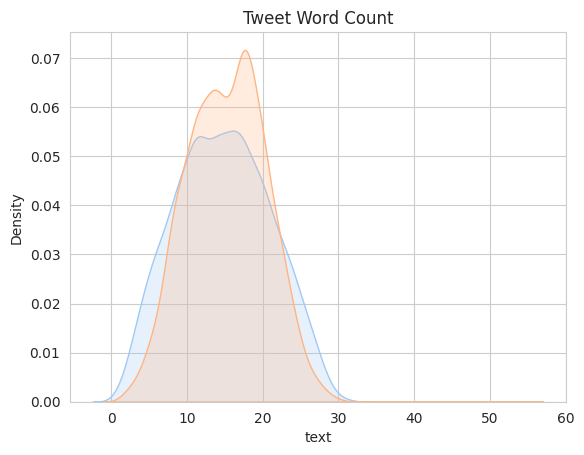

In [4]:
# Create graphs of the word count
train_lenghts = train_df["text"].str.split(" ").apply(lambda x: len(x))

sns.kdeplot(train_lenghts[train_df['target'] == 0], fill = True, label = 'Not disaster')
sns.kdeplot(train_lenghts[train_df['target'] == 1], fill = True, label = 'Disaster')

plt.title('Tweet Word Count')
plt.show()

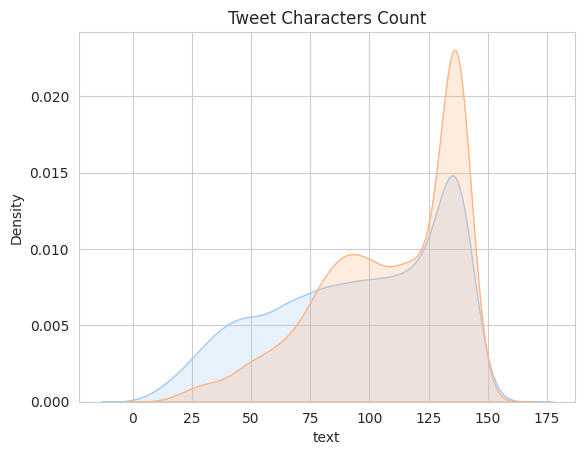

In [5]:
# Create graphs of the char lenght
train_lenghts = train_df["text"].str.len()

sns.kdeplot(train_lenghts[train_df['target'] == 0], fill = True, label = 'Not disaster')
sns.kdeplot(train_lenghts[train_df['target'] == 1], fill = True, label = 'Disaster')

plt.title('Tweet Characters Count')
plt.show()

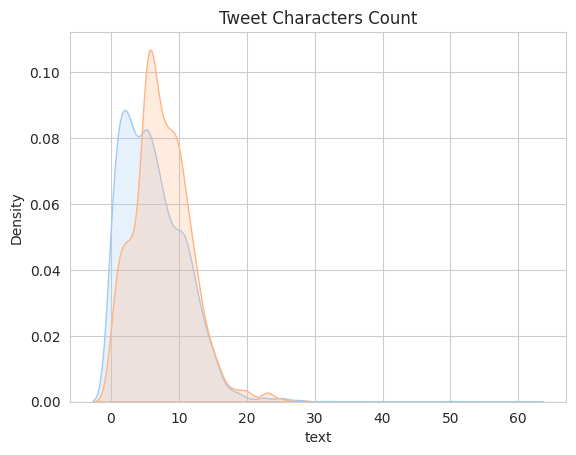

In [6]:
# Create graphs of the punctuation
train_lenghts = train_df["text"].apply(lambda x: len([char for char in x if char in string.punctuation]))

sns.kdeplot(train_lenghts[train_df['target'] == 0], fill = True, label = 'Not disaster')
sns.kdeplot(train_lenghts[train_df['target'] == 1], fill = True, label = 'Disaster')

plt.title('Tweet Characters Count')
plt.show()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


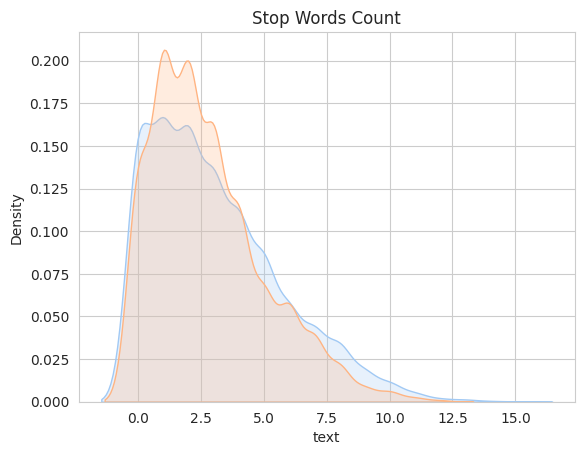

In [7]:
import nltk
from nltk.corpus import stopwords
from collections import Counter

# We count the stopwords on the data to see if there is a significant difference between the
# disasters and non disaters
nltk.download('stopwords')

def analyze_stopwords(texts):
    stop_words = set(stopwords.words('english'))
    all_words = ' '.join(texts).split()
    stopwords_freq = Counter(word for word in all_words if word.lower() in stop_words)

    top = [i[0] for i in stopwords_freq.most_common(30)]
    return top

stop_words = analyze_stopwords(train_df["text"])

train_stop = train_df["text"].apply(lambda x: len([i for i in x.split(" ") if i in stop_words]))

# Plot the results
sns.kdeplot(train_stop[train_df['target'] == 0], fill = True, label = 'Not disaster')
sns.kdeplot(train_stop[train_df['target'] == 1], fill = True, label = 'Disaster')

plt.title('Stop Words Count')
plt.show()

We can observe on the distributions that they are practicly the same, so there is no bias in the classification task caused by the length of the tweets, the puntuation or the stopwords quantity. Once we have seen this, we proceed to start with the model Architecture, in this particular case, the variables that we checked on the Exploratory Data Analysis doesn´t provide useful variables to our model.

<h1>Model Architecture</h1>

In [8]:
# We split the data into train and validation
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_df["text"], train_df["target"],
                                                      test_size = .1, random_state = 1)

<h3>How do we prepare the text for the analysis?</h3>

1. Eliminate the newlines and tabs
2. Replace URLs with the word 'http', we don´t want to lose data so we replace all links to 'http'
3. Convert the text to lowercase, there is no distinction between 'Ablaze' and 'ablaze'
4. Eliminate Stopwords from the text, for example 'the', 'then', 'i', 'our', etc.
5. Remove characters that are not letters, numbers, hashtags, apostrophes, or spaces
6. Remove extra white spaces, for example, 'Natural      Disaster' becomes 'Natural Disaster'
7. Lematize the text, for example, 'computers' becomes 'computer'

In [9]:
import spacy
import re
from nltk.corpus import stopwords
import nltk

# Load the spaCy model for natural language processing
nlp = spacy.load("en_core_web_sm")

# Download the NLTK stopwords set
nltk.download('stopwords')

# Function to lemmatize the text using spaCy
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

# Function to clean the text
def clean_text(df):
    # Remove special characters such as newlines and tabs
    df = df.str.replace('\n', ' ')
    df = df.str.replace('\t', ' ')

    # Replace URLs with the word 'http'
    url = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    df = df.str.replace(url, 'http', regex=True)

    # Convert the text to lowercase
    df = df.str.lower()

    # Remove stopwords using the NLTK stopwords set
    stop_words = set(stopwords.words())
    df = df.apply(lambda text: " ".join([token for token in text.split(" ") if token not in stop_words]))

    # Remove characters that are not letters, numbers, apostrophes, or spaces
    df = df.str.replace("[^a-zA-Z#' ]", ' ', regex=True)

    # Remove extra whitespaces
    df = df.apply(lambda x: re.sub(r'\s+', ' ', x))

    # Lemmatize the text using the previously defined function
    df = df.apply(lemmatize_text)

    return df

print(f"Example before cleaning: {list(X_train)[0]}")

X_train = clean_text(X_train)
X_valid = clean_text(X_valid)

print(f"Example after cleaning: {list(X_train)[0]}")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Example before cleaning: Our builder is having a dental emergency. Which has ruined my plan to emotionally blackmail him this afternoon with my bump.
Example after cleaning: builder dental emergency ruin plan emotionally blackmail afternoon bump


<h3>How does the model "reads" this text?</h3>

We need to tokenize the texts, which means the data pass from being in the form 'Natural disaster' to the form [11, 25], this helps the computer to establish a number to each word.

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Configure the tokenizer
tokenizer = Tokenizer(oov_token='<OOV>')

# Adjust the tokenizer to the training set
tokenizer.fit_on_texts(X_train)

# Obtain sequences of the texts
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_valid_sequences = tokenizer.texts_to_sequences(X_valid)

Then we pad each sequence, making all the sequences the same lenght, filling the blank spaces with zeros, in this case we are using a padding of type 'pre' to leave the data at the end.
<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*CPLhZoVSTCWgAxe2LKXoOA.png">

**(Mo, 2020)**

In [11]:
max_length = np.max([len(x) for x in X_train_sequences])

# Padding para que todas las secuencias tengan la misma longitud
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='pre')
X_valid_padded = pad_sequences(X_valid_sequences, maxlen=max_length, padding='pre')

<h3>Model</h3>
The model used will be a kind of RNN called Gated Recurrent Units (GRU) are a type of recurrent neural network (RNN) designed for processing sequential data, such as text. They introduce "gates" mechanisms that regulate the flow of information, addressing issues like the vanishing gradient problem in vanilla RNNs. GRUs are computationally efficient and commonly used in Natural Language Processing (NLP) tasks due to their ability to capture long-term dependencies in sequences of words.
The model consists of:

1. Embedding Layer - This layer reduces de dimensionality of the data and relates similar words.
2. GRU Layer - This layer process the sequences.
3. Convolutional 1D - These three layers enchance the model capability to learn paterns.
4. Flatten - This layer takes the previous output and make it 1D.
5. Dense and Dropout - This layer classifies the text based in the previous output, the Dropout reduce the overfitting risk and improves the model convergence speed.
6. Dense(Sigmoid) - This layer takes the previous output and returns a probability.

In [41]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras import metrics

vocab_size = len(tokenizer.word_counts) + 30
embedding_dim = 50
gru_units_1 = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

model.add(GRU(units=gru_units_1, dropout = .3, recurrent_dropout = .3, return_sequences = True))

model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))

model.add(Flatten())

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(rate=0.3))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 25, 50)            655100    
                                                                 
 gru_6 (GRU)                 (None, 25, 32)            8064      
                                                                 
 conv1d_18 (Conv1D)          (None, 24, 64)            4160      
                                                                 
 conv1d_19 (Conv1D)          (None, 23, 64)            8256      
                                                                 
 conv1d_20 (Conv1D)          (None, 22, 64)            8256      
                                                                 
 flatten_6 (Flatten)         (None, 1408)              0         
                                                                 
 dense_12 (Dense)            (None, 256)              

<h1>Results and Analysis</h1>

In [42]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
from keras.callbacks import Callback
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import LearningRateScheduler

class F1ScoreCallback(Callback):
    def __init__(self, validation_data=(), threshold=0.5):
        super(Callback, self).__init__()

        self.validation_data = validation_data
        self.threshold = threshold
        self.f1_scores = [0]

    def on_epoch_end(self, epoch, logs={}):
        x_val, y_val = self.validation_data
        y_pred = np.round(self.model.predict(x_val))
        f1 = f1_score(y_val, y_pred, average='binary')
        if f1 > np.max(self.f1_scores):
            self.model.save_weights("BestModelf1.keras")
            print(f' F1 Score improved: {f1}')
        else:
            print(f' F1 Score did not improve: {f1}')
        self.f1_scores.append(f1)

f1score_callback = F1ScoreCallback(validation_data=(X_valid_padded, y_valid))

<h3>Hyper-Parameter Tuning</h3>

**First Training**

In the initial training of the model, we utilized a learning rate of 0.001 and ran the training for 8 epochs. However, the learning rate was found to be excessively large, as evident from the chart. This resulted in suboptimal convergence of the model and an explosive gradient.

In [24]:
#Definition of the custom scheduler that reduce the learning rate after the second epoch
def scheduler(epoch):
    return 0.001

lr_scheduler = LearningRateScheduler(scheduler)

# Entrenar el modelo
history = model.fit(X_train_padded, y_train, epochs=8, batch_size=32, validation_data=(X_valid_padded, y_valid), callbacks=[f1score_callback, lr_scheduler])

Epoch 1/8
24/24 [==============================] - 1s 7ms/step loss: 0.5366 - accuracy: 
 F1 Score improved: 0.7272727272727273
215/215 [==============================] - 12s 38ms/step - loss: 0.5364 - accuracy: 0.7268 - val_loss: 0.4687 - val_accuracy: 0.7953 - lr: 0.0010
Epoch 2/8
24/24 [==============================] - 0s 7ms/step loss: 0.3192 - accuracy: 
 F1 Score improved: 0.7290640394088669
215/215 [==============================] - 8s 35ms/step - loss: 0.3192 - accuracy: 0.8691 - val_loss: 0.4851 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 3/8
24/24 [==============================] - 0s 7ms/step loss: 0.2027 - accuracy
 F1 Score did not improve: 0.7261146496815287
215/215 [==============================] - 7s 33ms/step - loss: 0.2027 - accuracy: 0.9256 - val_loss: 0.6055 - val_accuracy: 0.7743 - lr: 0.0010
Epoch 4/8
24/24 [==============================] - 0s 7ms/step loss: 0.1451 - accuracy
 F1 Score improved: 0.7309486780715397
215/215 [==============================] - 8s 35m

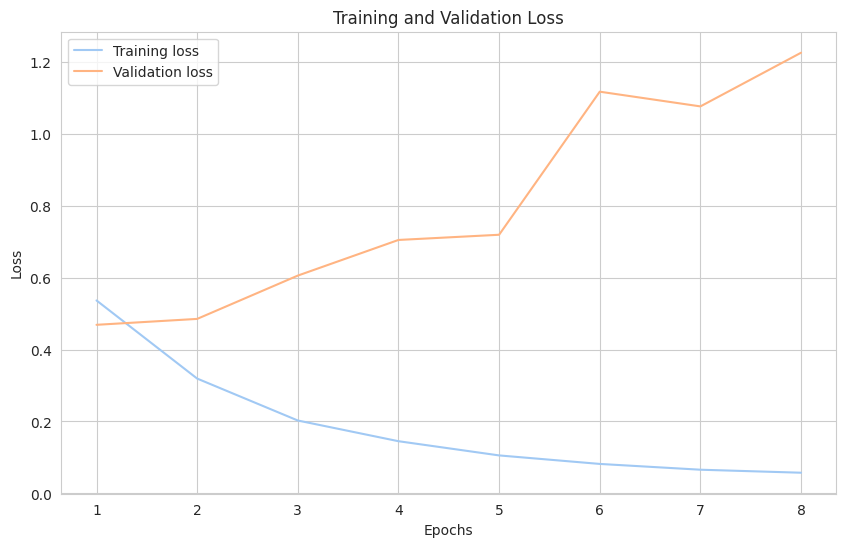

In [26]:
#Model plot of the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
h = pd.DataFrame(history.history)
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Second Training**

This time the learning rate was reduced to .0001 causing a much better convergence of the mode. But as we can see on the chart, in a few epochs the gradient explode again.

In [29]:
#Definition of the custom scheduler that reduce the learning rate after the second epoch
def scheduler(epoch):
    return 0.0001

lr_scheduler = LearningRateScheduler(scheduler)

# Entrenar el modelo
history = model.fit(X_train_padded, y_train, epochs=8, batch_size=32, validation_data=(X_valid_padded, y_valid), callbacks=[f1score_callback, lr_scheduler])

Epoch 1/8
24/24 [==============================] - 1s 7ms/step loss: 0.6689 - accuracy
 F1 Score did not improve: 0.6035889070146819
215/215 [==============================] - 12s 37ms/step - loss: 0.6689 - accuracy: 0.5901 - val_loss: 0.6196 - val_accuracy: 0.6811 - lr: 1.0000e-04
Epoch 2/8
24/24 [==============================] - 0s 7ms/step loss: 0.5129 - accuracy
 F1 Score did not improve: 0.7256637168141593
215/215 [==============================] - 7s 33ms/step - loss: 0.5129 - accuracy: 0.7593 - val_loss: 0.5257 - val_accuracy: 0.7559 - lr: 1.0000e-04
Epoch 3/8
24/24 [==============================] - 0s 6ms/step loss: 0.3869 - accuracy: 
 F1 Score improved: 0.7377777777777778
215/215 [==============================] - 7s 33ms/step - loss: 0.3869 - accuracy: 0.8308 - val_loss: 0.5168 - val_accuracy: 0.7677 - lr: 1.0000e-04
Epoch 4/8
24/24 [==============================] - 0s 7ms/step loss: 0.3298 - accuracy: 
 F1 Score did not improve: 0.7358490566037735
215/215 [==============

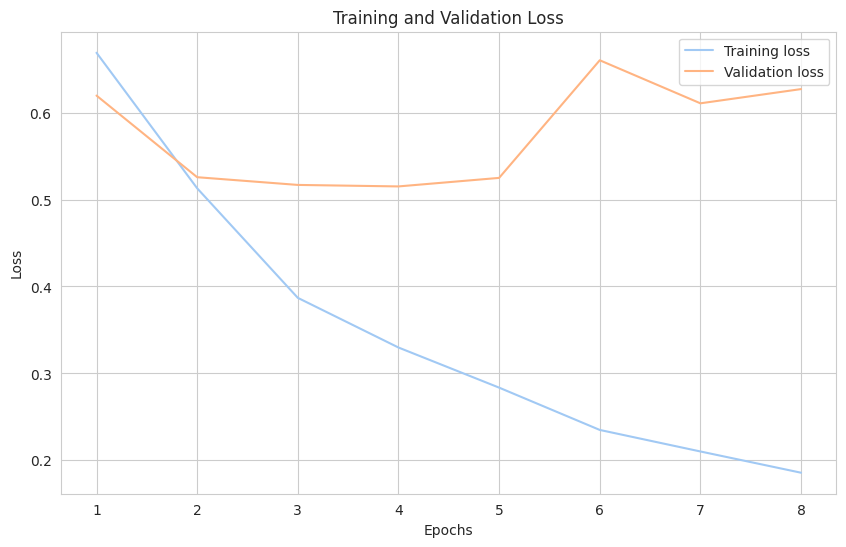

In [30]:
#Model plot of the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
h = pd.DataFrame(history.history)
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Final Training**

On the last training the learning rate was augmented to .00015 and a learning rate scheduler was implemented. The scheduler played a crucial role controling the explosive gradient by reducing it by halving it each epoch after the second one. The number of epochs was also reduced to 5 instead of 8. These adjustmentes improved the overall performance of the model, and had a great impact on the convergence of the model.

In [43]:
#Definition of the custom scheduler that reduce the learning rate after the second epoch
def scheduler(epoch):
    if epoch < 2:
        return 0.00015
    else:
        return 0.00015 * (0.5 ** (epoch))

lr_scheduler = LearningRateScheduler(scheduler)

# Entrenar el modelo
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_data=(X_valid_padded, y_valid), callbacks=[f1score_callback, lr_scheduler])

Epoch 1/5
24/24 [==============================] - 1s 6ms/step loss: 0.6551 - accuracy: 
 F1 Score improved: 0.6747720364741642
215/215 [==============================] - 13s 36ms/step - loss: 0.6551 - accuracy: 0.6104 - val_loss: 0.5713 - val_accuracy: 0.7192 - lr: 1.5000e-04
Epoch 2/5
24/24 [==============================] - 0s 7ms/step loss: 0.4583 - accuracy: 
 F1 Score improved: 0.7209705372616985
215/215 [==============================] - 7s 34ms/step - loss: 0.4583 - accuracy: 0.7936 - val_loss: 0.4775 - val_accuracy: 0.7887 - lr: 1.5000e-04
Epoch 3/5
24/24 [==============================] - 0s 7ms/step loss: 0.3428 - accuracy
 F1 Score did not improve: 0.7120418848167539
215/215 [==============================] - 7s 32ms/step - loss: 0.3429 - accuracy: 0.8583 - val_loss: 0.5011 - val_accuracy: 0.7835 - lr: 3.7500e-05
Epoch 4/5
24/24 [==============================] - 0s 6ms/step loss: 0.3221 - accuracy: 
 F1 Score improved: 0.7341337907375645
215/215 [==========================

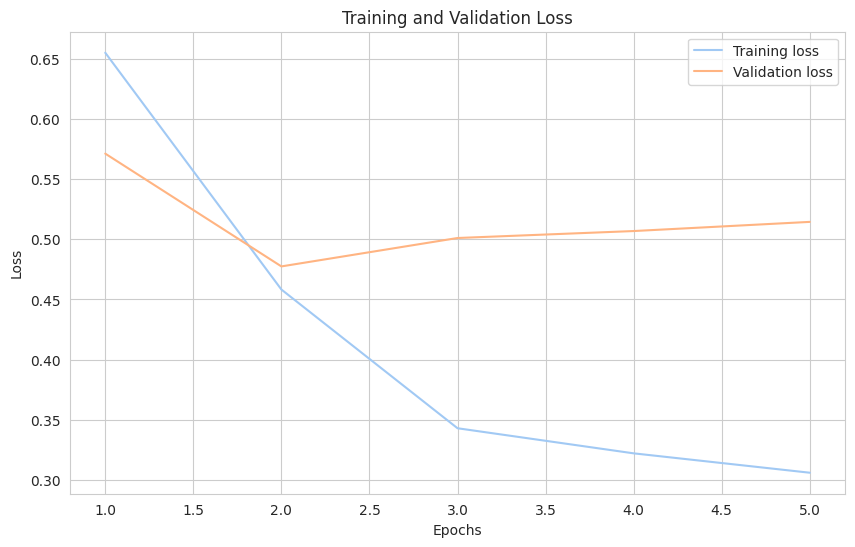

In [44]:
#Model plot of the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
h = pd.DataFrame(history.history)
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<h3>Final Submission</h3>

In [45]:
df_test = clean_text(test_df["text"])

X_test = tokenizer.texts_to_sequences(df_test)
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='pre')

model.load_weights("/kaggle/working/BestModelf1.keras")
predictions = model.predict(X_test_padded)

102/102 [==============================] - 1s 6ms/step


In [46]:
submission = test_df.copy()
submission["target"] = predictions
submission.drop(columns = ["keyword", "location", "text"], inplace = True)

submission["target"] = submission["target"].round().astype(int)
submission.to_csv("sub.csv", index = False)

<h1>Conclusions</h1>

The objective of this project was satisfactory fulfilled, we constructed a Recurrent Neural Networls (RNN) architecture from scratch. Applying different machine learning concepts an techniques, gaining a deeper understand of the Natural Language Processing (NLP). All of this by solving a very important issue, the identification of real disasters on the social media. This improvement can result very beneficial by reducing the risk of fake news or a fake alarm on the social media, applying this classification to every tweet before it is uploaded we can prevent the fake news or the false alarms to cause panic, instead, we can mark the real posts as a verified disaster. Also, this focus can result very profitable to the media, reducing the time that required to cover the news events.

For future investigations, one variable that wasn´t take into acount in this analysis are the emojis, which are widely used on the social media to express emotions. Adding this to the analysis can add very useful information and improve the overall performance of the model. 

Aditionally, it may be convenient to use a pre-trained classifier, it was not used here, because, one of the objectives of this project was to develop a RNN architecture from scratch.

**Bibliography**

Osman, M. (2018, November 26). Estadísticas Impresionantes de Twitter y Datos Importantes Sobre Nuestra Red Favorita. Retrieved March 2, 2024, from Kinsta® website: https://kinsta.com/es/blog/estadisticas-twitter/#:~:text=A%20pesar%20de%20este%20gran,millones%20de%20Tweets%20al%20d%C3%ADa.

Mo, K. (2020, August 17). Hands-on NLP Deep Learning Model Preparation in TensorFlow 2.X. Retrieved March 3, 2024, from Medium website: https://towardsdatascience.com/hands-on-nlp-deep-learning-model-preparation-in-tensorflow-2-x-2e8c9f3c7633
